# Converting a Pytorch neural etwork to do-mpc

In [1]:
import os
import sys
import torch
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)
import do_mpc

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/PAS/Work/do-mpc_approx_mpc/documentation/source/example_gallery/../../../do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/PAS/Work/do-mpc_approx_mpc/documentation/source/example_gallery/../../../do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## real model
Here the real model is a mass spring damper system. It has 2 states, namely 'position' and 'velocity'. It has 1 input, which is 'f_external'. The model is a force balance.

In [3]:
# init
real_model = do_mpc.model.Model('continuous', symvar_type='SX')

# Define the states
position = real_model.set_variable(var_type='_x', var_name='position', shape=(1,1))
velocity = real_model.set_variable(var_type='_x', var_name='velocity', shape=(1,1))

# Define the control inputs
f_external = real_model.set_variable(var_type='_u', var_name='f_external', shape=(1,1))

# constants
k = 10      # spring constant
c = 2       # damping constant
mass = 0.1  # mass of the object

# Define the model equations
real_model.set_rhs('position', velocity)
real_model.set_rhs('velocity', (-k*position - c*velocity + f_external)/mass)

# model setup
real_model.setup()

## real simulator

In [4]:
# init
real_simulator = do_mpc.simulator.Simulator(real_model)

# set t_step
real_simulator.set_param(t_step = 0.1)

# simulator setup
real_simulator.setup()

## neural network
To approximate the simple spring damper system a neural network is initialized consisting of one hidden layer with 10 nodes. The input layer starts with 3 nodes as there are 2 states and 1 input. The neural network mimics a simulator, thus the output is a linear layer with shape 2. Also the activation layer chosen is tanh. This is done since this activation function is continuously differentiable. Please be wary of choosing any non smooth activation layer like relu, as converting it to casadi could be problematic.

In [5]:
# Build the neural network dynamically based on the number of layers
layers = []

# Input layer (from input_size to the first hidden layer)
layers.append(torch.nn.Linear(3, 10))
layers.append(torch.nn.Tanh())

# Output layer (from the last hidden layer to output_size)
layers.append(torch.nn.Linear(10, 2))

# Combine all layers into a sequential model
nn_model = torch.nn.Sequential(*layers)

In [6]:
print(nn_model)

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=2, bias=True)
)


Loading pre trained weights for this exact neural network.

In [7]:
nn_model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

## the conversion
Here we generate a 'do_mpc.model.Model', this is where we store the converted neural network equations.

In [8]:
# init
surrogate_model = do_mpc.model.Model(model_type='discrete', symvar_type='SX')

Next we generate two variables, mimicking the the system states and the inputs.

In [9]:
# state variables
states = surrogate_model.set_variable(var_type='_x', var_name='states', shape=(2, 1))

# inputs
inputs = surrogate_model.set_variable(var_type='_u', var_name='inputs', shape=(1, 1))

The neural network is trained in such a way that the states are stacked before the inputs. This order is not necessary but must remain consistent.

In [10]:
# stacked inputs and states
input_layer = ca.vertcat(states, inputs)

The is where the neural network is unraveled and converted to it's equivalent casadi operations. For now this is able to understand two kinds of layers. 'Linear' layer reads the weights and bias from the pytorch model and converts them to casadi. Keep in mind casadi is capable of storing float64 only. So, incase you are using any other datatype, and convert to casadi, know that casadi does all it's internal calculation at float64, leading to small error in conversion. Additionally, this code is able to read 'tanh' layers.

In [11]:
# reading the layers and the biases
for i, layer in enumerate(nn_model):

    # linear transformations
    if isinstance(layer, torch.nn.Linear):
        # extracting weight and bias
        weight = layer.weight.cpu().detach().numpy()
        bias = layer.bias.cpu().detach().numpy()

        if i == 0:
            output_layer = ca.mtimes(weight, input_layer) + bias

        else:
            output_layer = ca.mtimes(weight, output_layer) + bias

    elif isinstance(layer, torch.nn.Tanh):
        if i == 0:
            output_layer = ca.tanh(input_layer)

        else:
            output_layer = ca.tanh(output_layer)

    else:
        raise RuntimeError('{} not supported!'.format(layer))

Once we have the 'output_layer' expression, we can push it as the rhs.

In [12]:
# setting up rhs
surrogate_model.set_rhs('states', output_layer)

Finally, setting up the surrogate model.

In [13]:
# setting rhs
surrogate_model.setup()

## generate a surrogate simulator
Initializing a new simulator class to evaluate the surrogate model

In [14]:
surrogate_simulator = do_mpc.simulator.Simulator(model=surrogate_model)

here the t_step is provided.

In [15]:
surrogate_simulator.set_param(t_step=0.1)

Finally, the surrogate simulator is setup.

In [16]:
surrogate_simulator.setup()

## MPC
Now we generate an MPC class with the surrogate model, to do some set-point tracking.

In [17]:
surrogate_mpc = do_mpc.controller.MPC(model=surrogate_model)

The time step is pushed to the mpc class. Also the horizon of the mpc class is pushed.

In [18]:
surrogate_mpc.set_param(t_step=0.1)
surrogate_mpc.set_param(n_horizon=10)

The cost function is designed to track a set-point. Then th objective is pushed.

In [19]:
setpoint = 0.005
mterm = (setpoint - surrogate_model.x['states'][0])**2
surrogate_mpc.set_objective(mterm=mterm, lterm=mterm)

Additionally, an input penalty is added to improve the results.

In [20]:
surrogate_mpc.set_rterm(inputs=0.1)

Now the boundaries of the states and th inputs are provided to the mpc class.

In [21]:
lbx = np.array([-0.01, -2.65/100])
ubx = np.array([0.01, 2.65/100])
lbu = np.array([-0.1])
ubu = np.array([0.1])

surrogate_mpc.bounds['lower', '_x', 'states'] = lbx
surrogate_mpc.bounds['upper', '_x', 'states'] = ubx
surrogate_mpc.bounds['lower', '_u', 'inputs'] = lbu
surrogate_mpc.bounds['upper', '_u', 'inputs'] = ubu

Finally the mpc can be setup

In [22]:
surrogate_mpc.setup()

# initializing
The initial point is chosen as zero, which is within the state within the state boundaries.

In [23]:
# random state inside the state boundaries
x0 = np.array([0.004, 0.0])
real_simulator.x0 = x0
surrogate_mpc.x0 = x0
surrogate_simulator.x0 = x0

real_simulator.set_initial_guess()
surrogate_simulator.set_initial_guess()
surrogate_mpc.set_initial_guess()

## simulation loop

This is the main simulation loop. Data is also store for plots.

In [24]:
x0_real_data = [x0.reshape((1, -1))]
x0_surrogate_data = [x0.reshape((1, -1))]
u0_data = []

for _ in range(50):

    # random input inside the input boundaries
    u_0 = surrogate_mpc.make_step(x0)

    # simulation steps
    x0_real = real_simulator.make_step(u0=u_0)
    x0_surrogate = surrogate_simulator.make_step(u0=u_0)

    # data stored for plots
    x0_real_data.append(x0_real.reshape((1, -1)))
    x0_surrogate_data.append(x0_surrogate.reshape((1, -1)))
    u0_data.append(u_0.reshape((1, -1)))

x0_real_data = np.vstack(x0_real_data)
x0_surrogate_data = np.vstack(x0_surrogate_data)
u0_data = np.vstack(u0_data)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       82
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       70

Total number of variables............................:       32
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       28
                     variables with only upper bounds:        0
Total number of equality constraints.................:       22
Total number of inequality c

## plot
Each profile is individually plotted.

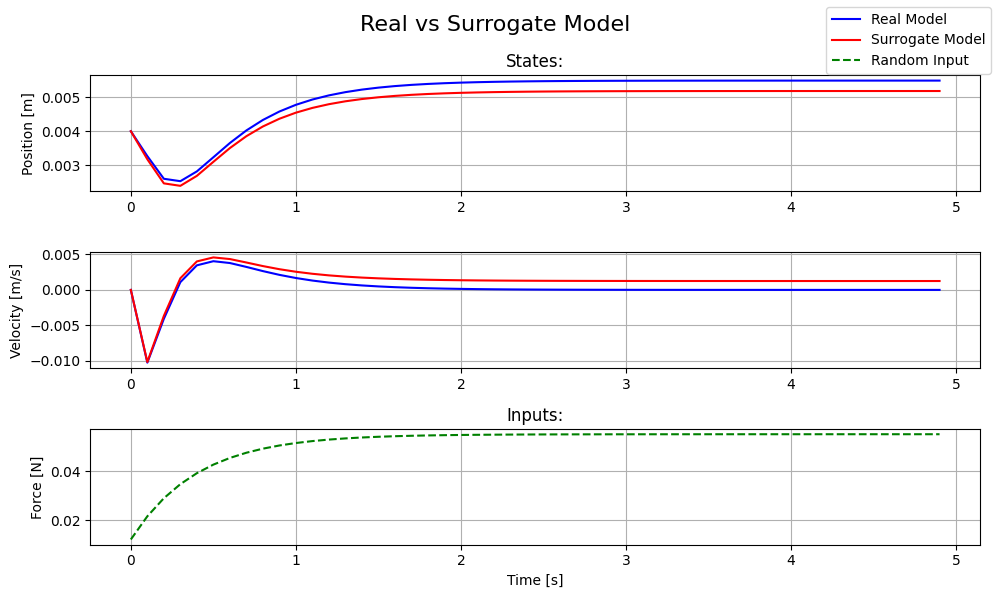

In [25]:
fig, ax = plt.subplots(3, figsize=(10, 6))

ax[0].plot(real_simulator.data['_time'], x0_real_data[:-1, 0], 'b', label='Real Model')
ax[0].plot(surrogate_simulator.data['_time'], x0_surrogate_data[:-1, 0], 'r', label='Surrogate Model')
ax[0].set_ylabel('Position [m]')
ax[0].set_title('States:')
ax[0].grid()

ax[1].plot(real_simulator.data['_time'], x0_real_data[:-1, 1], 'b')
ax[1].plot(surrogate_simulator.data['_time'], x0_surrogate_data[:-1, 1], 'r')
ax[1].set_ylabel('Velocity [m/s]')
ax[1].grid()

ax[2].plot(surrogate_simulator.data['_time'], u0_data[:, 0],'g--', label='Random Input')
ax[2].set_ylabel('Force [N]')
ax[2].set_xlabel('Time [s]')
ax[2].set_title('Inputs:')
ax[2].grid()

fig.legend()
fig.suptitle('Real vs Surrogate Model', fontsize=16)
plt.tight_layout()
plt.show()

Conversion completed!